# Important:

In order for this code to generate a model usable on the RBPi, you need to have the same versions of Librosa, Keras, and Tensorflow installed. The other package versions may not be significant, but if you are running into errors, check the package versions installable on the RBPi and install the same on the model creating device.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
import tensorflow
import librosa
import numpy as np
import random
import os
from pathlib import Path
from math import trunc
import matplotlib.pyplot as plt

cwd = os.getcwd()

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Imports all specified audio files, will only import if model.h5 doesn't exist.
# If training new model, manually delete old model
# Cannot keep training model if model was created previously (for next cell, code can be modified to accept this)
# Model closely based on Ajay Halthor's implementation
my_file = Path("model.h5")
if not my_file.is_file(): 
    print("No model found, creating new model.h...")
    
    # Initialize dataset array, source directories and file counts
    # Change counts according to own dataset and change split percentage if necessary
    D = []
    quietwoodpecker_dir = os.path.join(cwd, "data\woodpecker_quiet")
    quietCount = 1000
    woodpecker_dir = os.path.join(cwd, "data\woodpecker")
    woodCount = 2000
    notwoodpecker_dir= os.path.join(cwd, "data\\notwoodpecker")
    notwoodCount = 3000
    total = quietCount + woodCount + notwoodCount
    split= .75
    
    # Import audio from different sources. In our case there was seperate "woodepcker" directories
    # Appends data and assigns labels. Change value of counts according to personal dataset size.
    count = 0;
    for file in os.listdir(quietwoodpecker_dir):
        if(count==quietCount):
            break
        file_name = os.path.join(quietwoodpecker_dir, file)
        try:
            y, sr = librosa.load(file_name, duration=1)  
            ps = librosa.feature.melspectrogram(y=y, sr=sr)
            if ps.shape != (128, 44): continue
            D.append((ps, 1))
            count+=1
        except:
            print("File corrupted:", file_name)

    count = 0;
    for file in os.listdir(woodpecker_dir):
        if(count==woodCount):
            break
        file_name = os.path.join(woodpecker_dir, file)
        try:
            y, sr = librosa.load(file_name, duration=1)  
            ps = librosa.feature.melspectrogram(y=y, sr=sr)
            if ps.shape != (128, 44): continue
            D.append((ps, 1))
            count+=1
        except:
            print("File corrupted:", file_name)

    count=0
    for file in os.listdir(notwoodpecker_dir):
        if(count==notwoodCount):
            break
        file_name = os.path.join(notwoodpecker_dir, file)
        try:
            y, sr = librosa.load(file_name, duration=1)  
            ps = librosa.feature.melspectrogram(y=y, sr=sr)
            if ps.shape != (128, 44): continue
            D.append((ps, 0))
            count+=1
        except:
            print("File corrupted:", file_name)
            
    print("All audio has been imported...")
    
    #Shuffles the dataset and splits training and test set
    dataset = D
    random.shuffle(dataset)

    train = dataset[:trunc(total*split)]
    test = dataset[trunc(total*split):]

    X_train, y_train = zip(*train)
    X_test, y_test = zip(*test)

    # Reshape for CNN input
    X_train = np.array([x.reshape( (128, 44, 1) ) for x in X_train])
    X_test = np.array([x.reshape( (128, 44, 1) ) for x in X_test])

    # One-Hot encoding for classes
    y_train = np.array(to_categorical(y_train, 2))
    y_test = np.array(to_categorical(y_test, 2))
    
    # Layer creation for CNN
    model = Sequential()
    input_shape=(128, 44, 1)

    model.add(Convolution2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
    model.add(MaxPooling2D((4, 2), strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(48, (5, 5), padding="valid"))
    model.add(MaxPooling2D((4, 2), strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(48, (5, 5), padding="valid"))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(rate=0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=['accuracy'])
    
    # Fit model to data and evaluate, change epochs if necessary
    model.fit(x=X_train, y=y_train, epochs=2, batch_size=128, validation_data= (X_test, y_test))

    score = model.evaluate(x=X_test,y=y_test)
    model.save('model.h5')
    print("Model created and saved...")
else:
    print("Loading model from model.h5...")
    model = load_model('model.h5')

No model found, creating new model.h...
All audio has been imported...
Train on 4500 samples, validate on 1500 samples
Epoch 1/2
4500/4500 [==============================] - 288s 64ms/step - loss: 1.5699 - acc: 0.7918 - val_loss: 0.3559 - val_acc: 0.9260
Epoch 2/2
1500/1500 [==============================] - 3s 2ms/step
Model created and saved...


(1500, 128, 44, 1)
(1500,)
(1500, 2)


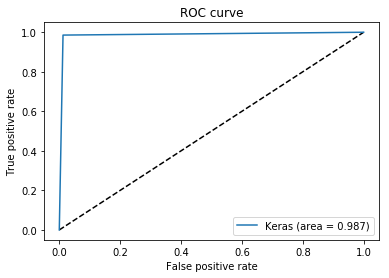

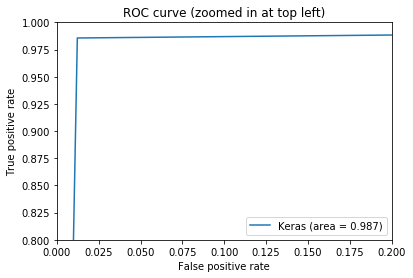

In [14]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.argmax(axis=1), y_pred_keras.argmax(axis=1))

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
# Simply test a file that is NOT part of the original dataset, just change path in next line
test_file = os.path.join(cwd, "data\\testing\\pecker.mp3")

y, sr = librosa.load(test_file, duration=1)  
ps = librosa.feature.melspectrogram(y=y, sr=sr)
test = np.array([ps.reshape( (128, 44, 1) )])

# This assumes acceptance rate of 50%, this may be djusted to how the device interprets audio
# For example,if most non-woodpecker audio falls under 5% and introducing woodpecker audio brings prediction up to 15%,
# you may want to change the threshold to 10%. This should also be done for the device code as well.
(notWood, Wood) = model.predict(test)[0]
label = "Woodpecker" if Wood > notWood else "Not Woodpecker"
proba = Wood if Wood > notWood else notWood
label = "{}: {:.2f}%".format(label, proba * 100)
print(label)

In [ ]:
# Only run this cell if getting poor results in previous cell. Will keep fitting data to obtain higher accuracy
# Warning, may overfit data, cannot be done for imported models
model.fit(x=X_train, y=y_train, epochs=1, batch_size=128, validation_data= (X_test, y_test))